# Project Overview and Business Problem

Magnetic Resonance Imaging (MRI) is a vital resource used in the clincial assement of patients with suspected Alzheimer disease, allowing clinicans to observe the structure of the brain. Atrophy of medial temporal structure are now considered valid diagnositc markers 




# Model Performance


# DataBase Understanding

Sources:
1. https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
2. https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

# Need to rewrite what is below 
This dataset comprises a mix of real and synthetic axial MRIs and was developed to rectify the class imbalance in the original Kaggle Alzheimer's dataset, which featured four categories: "No Impairment", "Very Mild Impairment", "Mild Impairment", and "Moderate Impairment". Each category had 100, 70, 28, and 2 patients, respectively, and each patient's brain was sliced into 32 horizontal axial MRIs.

The MRI images were acquired using a 1.5 Tesla MRI scanner with a T1-weighted sequence. The images have a resolution of 128x128 pixels and are in the “.jpg” format. All images have been pre-processed to remove the skull.

However, it is important to note that the synthetic MRIs were not verified by a radiologist. Therefore, any results or indications from this dataset may or may not resemble real-world patient's symptoms or patterns. Moreover, there are no threats to privacy as these synthetic MRIs do not resemble any real-world patients, .



## Loading and Viewing Data


In [60]:
#Importing Packages and modules

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import pandas as pd
import numpy as np
import os, shutil
import numpy as np
from math import ceil
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from pathlib import Path
from PIL import Image
import PIL

from skimage.feature import hog
from skimage import exposure
from skimage.transform import resize

import keras
from keras import models
from keras import layers
from keras.datasets import mnist
from tensorflow.keras import Sequential, Input
from keras.layers import Dense, Dropout, Conv2D, Flatten
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

tf.random.set_seed(42)
np.random.seed(42)


In [2]:
#Defining data Directories for ease of use
all_images_directory = 'data/all'
train_directory = 'data/train/'
test_directory = 'data/test/'
combined_datasets_directory = 'data/combined datasets/'


In [3]:
#Creating Dataframe for Data

#Pulling Paths for all images in testing set via recursive globbing
paths = [path.parts[-3:] for path in
         Path(all_images_directory).rglob('*.jpg')]

#Turning pulled path data into Dataframe
df = pd.DataFrame(data=paths, columns=['Folder', 'AD Label', 'Image'])
df

,Folder,AD Label,Image
0,all,No Impairment,NoImpairment (1373).jpg
1,all,No Impairment,4 (37).jpg
2,all,No Impairment,NoImpairment (1689).jpg
3,all,No Impairment,NoImpairment (1723).jpg
4,all,No Impairment,26 (81).jpg
...,...,...,...
11514,all,Mild Impairment,MildImpairment (2143).jpg
11515,all,Mild Impairment,MildImpairment (270).jpg
11516,all,Mild Impairment,MildImpairment (71).jpg
11517,all,Mild Impairment,MildImpairment (1295).jpg


In [4]:
#Pulling images from the data directory 
data = ImageDataGenerator(rescale=1/255).flow_from_directory(combined_datasets_directory,
                                target_size = (128, 128),
                                batch_size = 17919,
                                seed = 42, shuffle=False)
#Defining class names for ease of use
classes = data.class_indices.keys()
#Printing out classes
data.class_indices

Found 17919 images belonging to 4 classes.


{'Mild Impairment': 0,
 'Moderate Impairment': 1,
 'No Impairment': 2,
 'Very Mild Impairment': 3}

In [5]:
#Seperating Labels from images
images, labels = next(data)
print(labels[[9003,13244,2,3823]])


[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


The data labels have been one hot encoded into arrays of 4 digits representing the classes. These class codes are not intuitive so the next step is to build a helper function to quickly convert these class codes into the actual diagnosis for readability.

In [6]:
#Class codes and their labels for reference while building function
# [0.0, 0.0, 1.0, 0.0]: 'No Impairment',
# [0.0, 0.0, 0.0, 1.0]: 'Very Mild Impairment',
# [1.0, 0.0, 0.0, 0.0]: 'Mild Impairment',
# [0.0, 1.0, 0.0, 0.0]: 'Moderate Impairment' 


def class_code_to_label(class_code):
    '''
    Takes in a array that represents the class of an image in the AD dataset and replaces it with the string 
    that represents the class name.
    
    This was created so that the figures created for this project can easily be labeled with the AD diagnosis rather
    than the class code
    '''
    if class_code[2] == 1:
        return 'No Impairment'
    elif class_code[3] == 1:
        return 'Very Mild Impairment'
    elif class_code[0] == 1:
        return 'Mild Impairment'
    elif class_code[1] == 1:
        return 'Moderate Impairment'


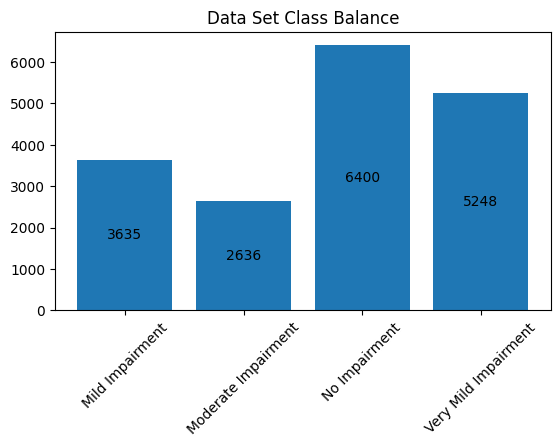

In [7]:
#Checking Class Balance 

bars = plt.bar(['Mild Impairment','Moderate Impairment','No Impairment','Very Mild Impairment'], sum(labels))
plt.xticks(rotation=45)
plt.title('Data Set Class Balance');
plt.gcf().subplots_adjust(bottom=0.3)
plt.bar_label(bars, label_type='center')
plt.savefig('./figures/dataset_class_balance.png')

The overall dataset is fairly balanced across classes as can be seen in the figure above. Next a preview of the image data for each class will be created for reference. 

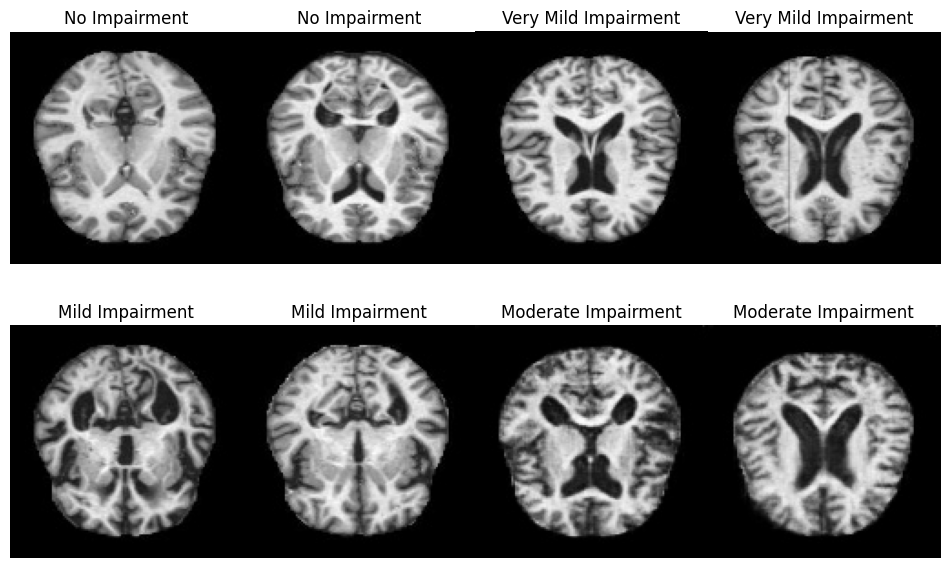

In [8]:
#List of 2 of each class for viewing sample
sample_image_indexes = [9002,9003,13244,13236,1,2,3823,3824]

#Plotting 8 Sample images
plt.figure(figsize=(12,7))
for num, index in enumerate(sample_image_indexes):
    plt.subplot(2,4,num+1)
    plt.gca().set_title(class_code_to_label(labels[index]))
    plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.imshow(images[index])

# Exploratory Data Analysis

A deep dive into the data will allow for a greater overall understanding of the data and help provide clues for what steps will need to be taken to produce the best possible model.

The classes will be seperated in order to better understand the differences between them. An average image as well as histograms of oriented gradients for each classification will be created and then compared to the other classes. 

In [9]:
#Creating Class based Datasets for class comparisons

#Creating Mild Dataset
mild_data = ImageDataGenerator(rescale=1./255).flow_from_directory(all_images_directory,
                                target_size = (128, 128),
                                batch_size = 2739,
                                seed = 42, classes=['Mild Impairment'])
#Creating Moderate Dataset
moderate_data = ImageDataGenerator(rescale=1./255).flow_from_directory(all_images_directory,
                                target_size = (128, 128),
                                batch_size = 2572,
                                seed = 42, classes=['Moderate Impairment'])
#Creating No Impairment Dataset
no_impair_data = ImageDataGenerator(rescale=1./255).flow_from_directory(all_images_directory,
                                target_size = (128, 128),
                                batch_size = 3200,
                                seed = 42, classes=['No Impairment'])
#Creating Very Mild Dataset
very_mild_data = ImageDataGenerator(rescale=1./255).flow_from_directory(all_images_directory,
                                target_size = (128, 128),
                                batch_size = 3008,
                                seed = 42, classes=['Very Mild Impairment'])



Found 2739 images belonging to 1 classes.
Found 2572 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 3008 images belonging to 1 classes.


In [10]:
#Seperating images and labels
mild_images, mild_labels = next(mild_data)
moderate_images, moderate_labels = next(moderate_data)
no_impair_images, no_impair_labels = next(no_impair_data)
very_mild_images, very_mild_labels = next(very_mild_data)

### Finding Average Image of each Class

In order to elucidate key structural differences between the classes, the average image for each class will be computed. Each average image will then be compared with each class in order to see the average structual differences between the different AD severity levels.

In [11]:
def create_average_image(images):
    '''
    Input a series of images or arrays that correspond to images and the output is two values, 
    the average array and the average image of all inputs
    '''
    #Turn each input image into an array
    images_arrays = np.array([np.array(im) for im in images])
    #Find the average of all of the arrays to create average image
    average_array = np.mean(images_arrays,axis=0)
    #Create image from average array and multiply by 255 for uint8 conversion
    ave_image = Image.fromarray((average_array*255).astype('uint8'))
    return average_array, ave_image

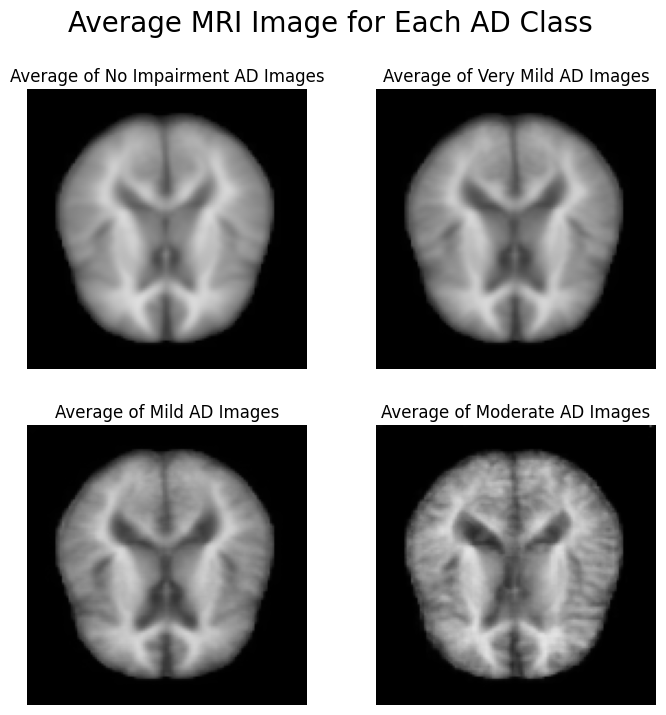

In [12]:
#Creating an Average image for each class
mild_mean_array, mild_mean_img = create_average_image(mild_images)
moderate_mean_array, moderate_mean_img = create_average_image(moderate_images)
no_impair_mean_array, no_impair_mean_img = create_average_image(no_impair_images)
very_mild_mean_array, very_mild_mean_img = create_average_image(very_mild_images)


#Visualizing all Average Images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
fig.suptitle('Average MRI Image for Each AD Class', size=20)
fig.subplots_adjust(wspace=0)

#Plotting No Impairment image
ax[0,0].imshow(no_impair_mean_array)
ax[0,0].set_title("Average of No Impairment AD Images")
ax[0,0].axis('off')

#Plotting Very Mild image
ax[0,1].imshow(very_mild_mean_array)
ax[0,1].set_title("Average of Very Mild AD Images")
ax[0,1].axis('off')

#Plotting Mild image
ax[1,0].imshow(mild_mean_array)
ax[1,0].set_title("Average of Mild AD Images")
ax[1,0].axis('off')

#Plotting Moderate image
ax[1,1].imshow(moderate_mean_array)
ax[1,1].set_title("Average of Moderate AD Images")
ax[1,1].axis('off')

plt.savefig('./figures/Class_Mean_Images.png')

Upon first glance it seem that atrophy increases as the severity of AD increases, this is evident in the loss of dense tissue as severity increases. In order to better understand the differences the images will compared directly.

# Comparing all Average Images


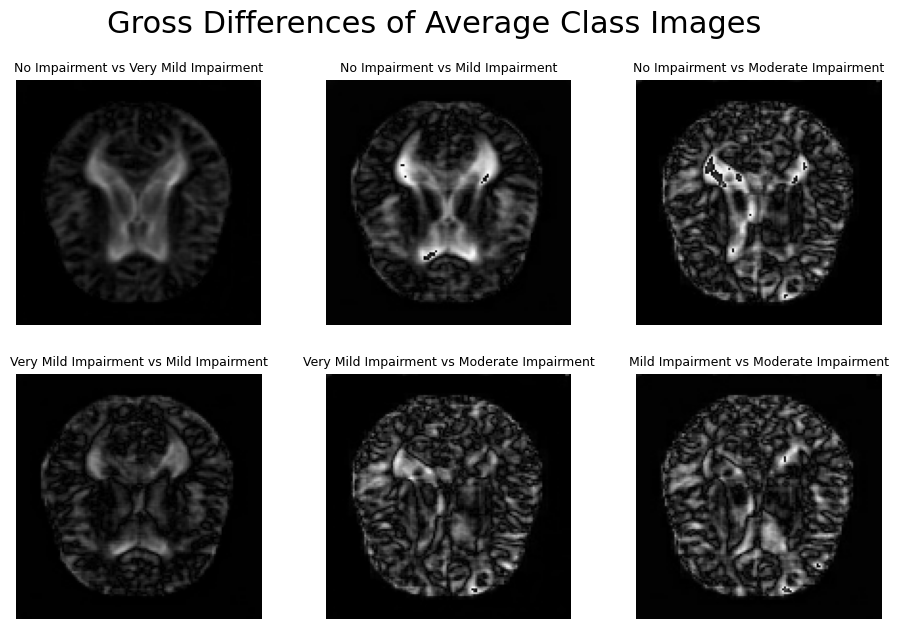

In [13]:
mean_arrays_dict = {'No Impairment': no_impair_mean_array, 
                    'Very Mild Impairment': very_mild_mean_array,
                    'Mild Impairment': mild_mean_array,
                    'Moderate Impairment':moderate_mean_array}
    
#Creating list of Mean image arrays to be looped through
mean_arrays_values =  list(mean_arrays_dict.values())
mean_arrays_keys = list(mean_arrays_dict.keys())

def compare_arrays(array1, array2):
    '''
    Input two different arrays that correspond to images, the array2 will be subtracted from array1 to create a 
    new array that represents the difference between to images. The new array is then converted into uint8 form. 
    
    The output is an array equal to the difference of the input array.
    '''
    #Subtracting moderate mean image from no impairment image to find differences
    difference_of_arrays = abs(array1 - array2)
    #Multipling resulting image by 255 for uint8 conversion
    compared_array = (difference_of_arrays*1020).astype(np.uint8)
    #plt.title(f"{array1} vs {array2}")
    return compared_array


compared_arrays = []

plt.figure(figsize=(12,7))
plt.suptitle('Gross Differences of Average Class Images', size=22)

ax = 0 

for i in range(len(mean_arrays_dict)):
    for j in range(i + 1, len(mean_arrays_dict)):
            img = compare_arrays(mean_arrays_values[i], mean_arrays_values[j])
            plt.subplot(2,3,ax+1)
            plt.subplots_adjust(wspace=0)
            compared_arrays.append(img)
            #Create title in string format"
            plt.gca().set_title('{:s} vs {:s}'.format(mean_arrays_keys[i] ,mean_arrays_keys[j]), fontsize=9)
            plt.axis('off')
            plt.subplots_adjust(wspace=0)
            plt.imshow(img)
            ax+=1
        
plt.savefig('./figures/Class_Mean_Comparisons.png')

In the figure above, lighter spots represent a greater difference, while darker spots represent less difference between the comparative images. Examining the top row, which compares no impairment to the other groups, it is clear that as AD severity increases, the structure of the brain changes more from the control group. 


It is important to note that the white color does not represent atrophy directly but simply differences between the color values in the images being compared. The trend within this figure is that structure changes are most drastic in more severe cases of AD when compared with the No Impairment group

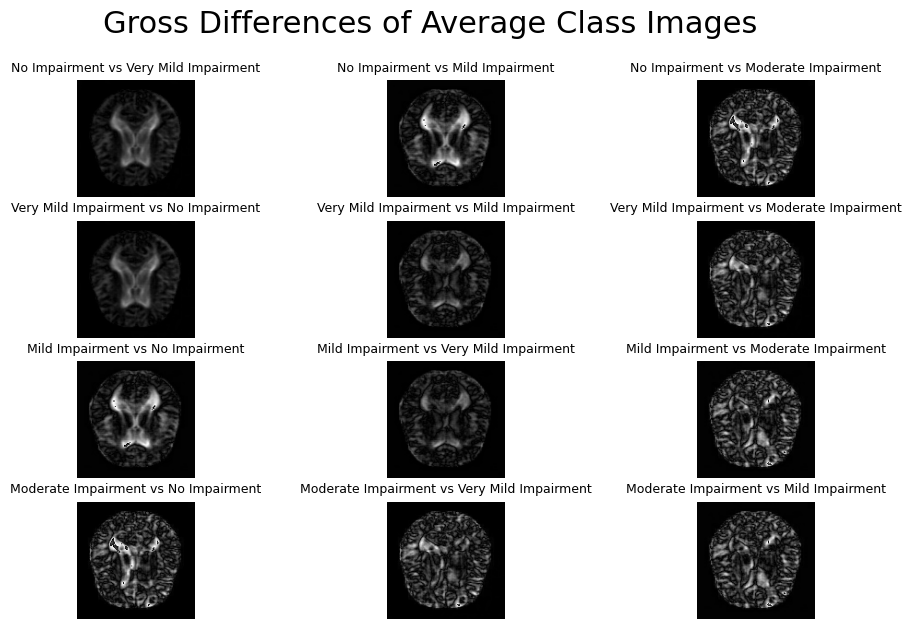

In [14]:
plt.figure(figsize=(12,7))
plt.suptitle('Gross Differences of Average Class Images', size=22)

ax = 0 

for i in range(len(mean_arrays_dict)):
    for j in range(len(mean_arrays_dict)):
        if i == j:
            continue
        else:
            img = compare_arrays(mean_arrays_values[i], mean_arrays_values[j])
            plt.subplot(4,3,ax+1)
            plt.subplots_adjust(wspace=0)
            compared_arrays.append(img)
            #Create title in string format"
            plt.gca().set_title('{:s} vs {:s}'.format(mean_arrays_keys[i] ,mean_arrays_keys[j]), fontsize=9)
            plt.axis('off')
            plt.subplots_adjust(wspace=0)
            plt.imshow(img)
            ax+=1
        
plt.savefig('./figures/Class_Mean_Comparisons.png')

## Feature Description through Histograms of Oriented Gradients 

Histograms of Oriented Gradients (HOGs)are feature descriptors that focus on the structure of an image and extract information on edge magnitudes as well as edge orientation in order to extract the most important information in the image.

In the current project HOGs will be used in order to compare the feature differences between classes. A model will also be trained on HOGs to test if this increases accuracy for the model through simplifing the input when compared with a the original image.

In [15]:
#Viewing Current image size
image = no_impair_mean_array
image.shape

(128, 128, 3)

In [16]:
moderate_mean_array

array([[[2.57109758e-02, 2.57109758e-02, 2.57109758e-02],
        [3.03171109e-02, 3.03171109e-02, 3.03171109e-02],
        [2.26357076e-02, 2.26357076e-02, 2.26357076e-02],
        ...,
        [3.26981813e-01, 3.26981813e-01, 3.26981813e-01],
        [6.72789812e-02, 6.72789812e-02, 6.72789812e-02],
        [2.12697708e-03, 2.12697708e-03, 2.12697708e-03]],

       [[1.88544225e-02, 1.88544225e-02, 1.88544225e-02],
        [1.09930756e-02, 1.09930756e-02, 1.09930756e-02],
        [3.31928278e-03, 3.31928278e-03, 3.31928278e-03],
        ...,
        [6.56689843e-03, 6.56689843e-03, 6.56689843e-03],
        [1.94248324e-03, 1.94248324e-03, 1.94248324e-03],
        [1.85710262e-03, 1.85710262e-03, 1.85710262e-03]],

       [[7.93606322e-03, 7.93606322e-03, 7.93606322e-03],
        [1.27923500e-03, 1.27923500e-03, 1.27923500e-03],
        [4.57414717e-06, 4.57414717e-06, 4.57414717e-06],
        ...,
        [2.82682502e-03, 2.82682502e-03, 2.82682502e-03],
        [1.97145506e-03, 1.97

In [32]:
def create_hog(image_array):
    '''
    Input is an array that corresponds to an image. the array is then process through sci-kit image hog function
    and then its rescales the exposure of the image. 
    
    Output is the hog image as well as t
    '''
    fd, hog_image = hog(image_array, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualize=True, channel_axis=2)
    h_image2 = exposure.rescale_intensity(hog_image, in_range=(0,.02))
    return h_image2 , fd



In [33]:
no_impair_hog, no_impair_hog_fd  = create_hog(no_impair_mean_array)
very_mild_hog, very_mild_hog_fd = create_hog(very_mild_mean_array)
mild_hog, mild_hog_fd = create_hog(mild_mean_array)
moderate_hog, moderate_hog_fd = create_hog(moderate_mean_array)

TypeError: 'numpy.ndarray' object is not callable

In [34]:
hog_list = [no_impair_hog, very_mild_hog, mild_hog, moderate_hog]

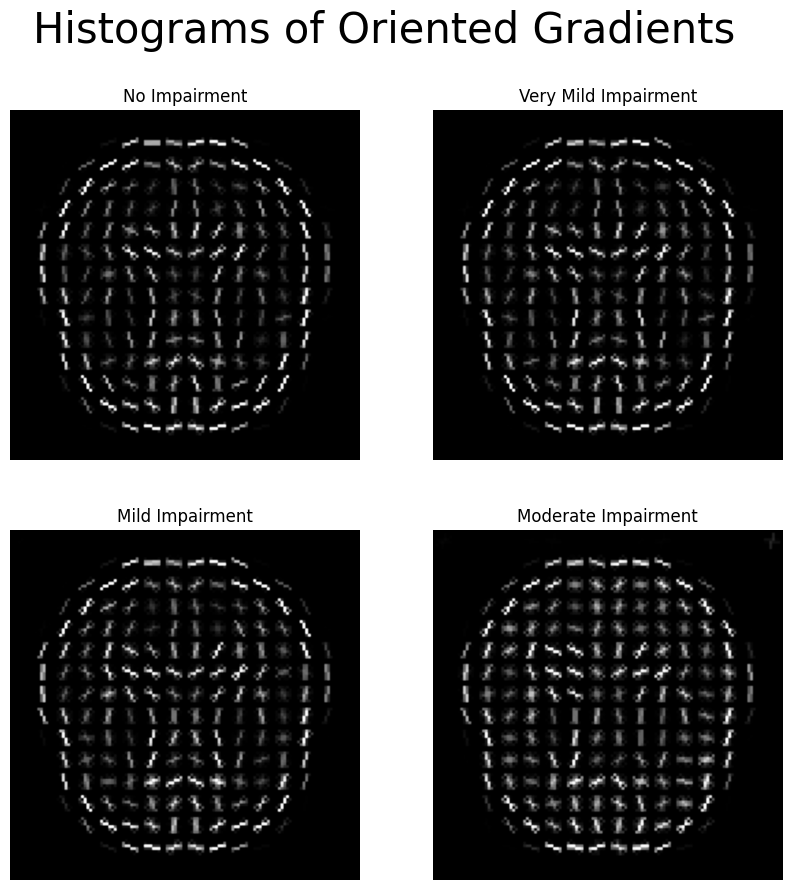

In [35]:
fig = plt.figure(figsize=(10,10), )
fig.suptitle("Histograms of Oriented Gradients", size=30)

hog_titles = ['No Impairment','Very Mild Impairment','Mild Impairment','Moderate Impairment']

for num, hog in enumerate(hog_list):
    fig.add_subplot(2,2,num+1)
    plt.title(hog_titles[num])
    plt.imshow(hog, cmap='Greys_r')
    plt.axis('off')

plt.savefig('./figures/Class_Mean_HOGs.png')

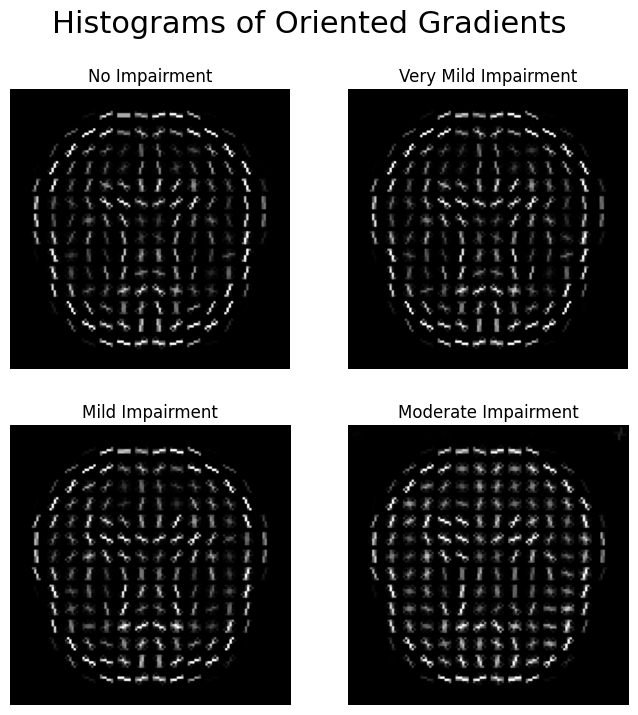

In [38]:
fig = plt.figure(figsize=(8,8) )
fig.suptitle("Histograms of Oriented Gradients", size=22)

hog_titles = ['No Impairment','Very Mild Impairment','Mild Impairment','Moderate Impairment']

for num, hog in enumerate(hog_list):
    fig.add_subplot(2,2,num+1)
    plt.title(hog_titles[num])
    plt.imshow(hog, cmap='Greys_r')
    plt.axis('off')

plt.savefig('./figures/Class_Mean_HOGs.png')

It is subtle but it can be seen that there are stronger gradients as AD severity progresses, this is evident by the increase in overall brightness along with additional orientations of the gradients in the more severe photos.

# Modeling

Before modeling can commence there are a few remaining steps that will need to be taken such as splitting the data set into a training, testing and validation group as well as building out a number of functions to help with model evaluation.

In [71]:
#Model Evaluation Helper Functions

def visualize_model_performance(results):
    '''
    Input is the results after fitting a CNN Sequential model and the output are two graphs, one plots the loss by epoch
    for the training and validation datasets and the second plots a similar graph for accuracy rather than loss.
    '''
    history = results.history
    
    #final_epoch_stats(results)
    
    plt.figure(figsize=(10,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Graph of Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Graph of Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()



def make_confusion_and_classification(model, model_name):
    '''
    The Inputs for this fuction are a model prior to being fit and a string that will act as the title of the
    visualization. The output creates a heatmapped confusion matrix as well as a classification report for the model.
    The testing set (X_test, y_test) is used for these visualizations, so that the metrics are based on data that is
    novel to the model.
    '''
    
    #Show model.evaluate results 
    eval_metrics = model.evaluate(X_train, y_train, verbose=0)
    print('The Accuracy for the training group was', eval_metrics[1]*100)
    print('The Loss for the training group was', eval_metrics[0])
    print('--------------------------------------')
    eval_metrics = model.evaluate(X_test, y_test, verbose=0)
    print('The Accuracy for the test group was', eval_metrics[1]*100)
    print('The Loss for the test group was', eval_metrics[0])
    
    #Make Predictions for model
    preds = model.predict(X_test)
    #Converting label predictions with argmax to show sentiment label
    preds = np.argmax(preds, axis=1)
    #Converting actual labels with argmax to match predictions
    y_test_arg=np.argmax(y_test, axis=1)
    #Create confusion matrix
    conmat = tf.math.confusion_matrix(y_test_arg, preds)
    
    #Create dataframe from confusion matrix
    val = np.mat(conmat)
    #classnames = list(set(y_train))
    df_cm = pd.DataFrame(val)
    
    #generate heatmap confusion matrix
    plt.figure()
    heatmap = sns.heatmap(df_cm, annot=True, cmap='Reds',fmt='g')
    heatmap.yaxis.set_ticklabels(classes, rotation=0)
    heatmap.xaxis.set_ticklabels(classes, rotation=40)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(model_name)
    plt.show()
    
    #generate classification report
    print(classification_report(y_test_arg ,preds))

## Train-Test Split




(17919, 128, 128, 3)
(17919, 4)


In [40]:
#Redefining data and labels for modeling
X = images
y = labels

#Splitting data set into train, test and validation sets at a ratio of 8:1:1
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)


In [53]:
#Converting training labels to Dataframe in which each column is a class marker to view class balance
y_train_df = pd.DataFrame(y_train, columns=classes)
y_train_df.sum(axis=0) 

Mild Impairment         2908.0
Moderate Impairment     2109.0
No Impairment           5120.0
Very Mild Impairment    4198.0
dtype: float32

The classes are not perfectly balanced throughout the training dataset, but they are balanced at a ratio of roughly \[3:2:5:4\] which is adequatly balanced for the present project

In [66]:
#Investigating shape of data prior to reshaping
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('-----------------------------')
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)
print('-----------------------------')
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)
print('-----------------------------')
print('X_rem Shape:', X_rem.shape)
print('y_rem Shape:', y_rem.shape)

X_train Shape: (14335, 49152)
y_train Shape: (14335, 4)
-----------------------------
X_val Shape: (1792, 49152)
y_val Shape: (1792, 4)
-----------------------------
X_test Shape: (1792, 49152)
y_test Shape: (1792, 4)
-----------------------------
X_rem Shape: (3584, 128, 128, 3)
y_rem Shape: (3584, 4)


The MLP classification model that will be built out takes vectors as inputs, so each image will have to be concatenated into a single 49152-dimensional vector due to the original image shape being 128\*128\*3. All of the images in this data set are the same size and will be concatenated in the same way so pixel positional information will remain intact after reshaping.

In [67]:
#Reshaping images into vectors
X_train = X_train.reshape(14335, 49152)
X_val = X_val.reshape(1792, 49152)
X_test = X_test.reshape(1792, 49152)
X_rem = X_rem.reshape(3584, 49152)

print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('-----------------------------')
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)
print('-----------------------------')
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)
print('-----------------------------')
print('X_rem Shape:', X_rem.shape)
print('y_rem Shape:', y_rem.shape)

X_train Shape: (14335, 49152)
y_train Shape: (14335, 4)
-----------------------------
X_val Shape: (1792, 49152)
y_val Shape: (1792, 4)
-----------------------------
X_test Shape: (1792, 49152)
y_test Shape: (1792, 4)
-----------------------------
X_rem Shape: (3584, 49152)
y_rem Shape: (3584, 4)


In [45]:
baseline_model = Sequential()

baseline_model.add(layers.Dense(128, activation='relu', input_shape=(49152,)))
baseline_model.add(layers.Dense(64, activation='relu'))
baseline_model.add(layers.Dense(4, activation='softmax'))

baseline_model.compile(optimizer='adam',metrics=['accuracy'], loss='categorical_crossentropy')
#baseline_model.summary()

In [46]:
#Creating Early stop based on when validation accuracy stops increasing and saving best model
early_stop = [EarlyStopping(monitor = 'val_accuracy', patience = 15, mode='max'),
              ModelCheckpoint(filepath='best models/best_model.h5', monitor='val_accuracy', save_best_only=True)]


In [47]:
baseline_results = baseline_model.fit(X_train, y_train, epochs=30, batch_size=50,
                                  validation_data=(X_val, y_val), verbose=1, callbacks=early_stop)


Epoch 1/30
287/287 [==============================] - 4s 14ms/step - loss: 1.1482 - accuracy: 0.6057 - val_loss: 0.6732 - val_accuracy: 0.6942
Epoch 2/30
  4/287 [..............................] - ETA: 6s - loss: 0.6922 - accuracy: 0.6950

/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 4s 12ms/step - loss: 0.6163 - accuracy: 0.7309 - val_loss: 0.5991 - val_accuracy: 0.7132
Epoch 3/30
287/287 [==============================] - 4s 12ms/step - loss: 0.4846 - accuracy: 0.7879 - val_loss: 0.5759 - val_accuracy: 0.7785
Epoch 4/30
287/287 [==============================] - 4s 12ms/step - loss: 0.3932 - accuracy: 0.8351 - val_loss: 0.3198 - val_accuracy: 0.8655
Epoch 5/30
287/287 [==============================] - 4s 12ms/step - loss: 0.3604 - accuracy: 0.8489 - val_loss: 0.3477 - val_accuracy: 0.8426
Epoch 6/30
287/287 [==============================] - 4s 13ms/step - loss: 0.3478 - accuracy: 0.8552 - val_loss: 0.5330 - val_accuracy: 0.7422
Epoch 7/30
287/287 [==============================] - 4s 13ms/step - loss: 0.4000 - accuracy: 0.8330 - val_loss: 0.8829 - val_accuracy: 0.7148
Epoch 8/30
287/287 [==============================] - 4s 13ms/step - loss: 0.3016 - accuracy: 0.8828 - val_loss: 0.2453 - val_accuracy: 0.9035
Epoch 9/30

The Accuracy for the training group was 97.96302914619446
The Loss for the training group was 0.06906656920909882
--------------------------------------
The Accuracy for the test group was 95.47991156578064
The Loss for the test group was 0.12572920322418213
56/56 [==============================] - 0s 3ms/step


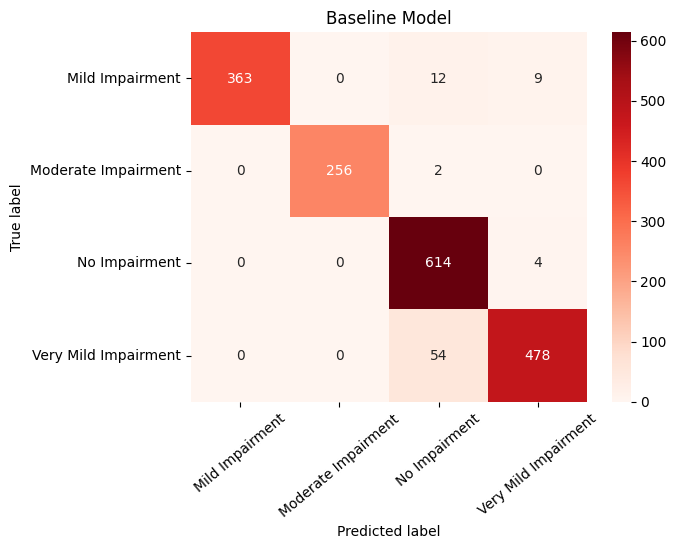

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       384
           1       1.00      0.99      1.00       258
           2       0.90      0.99      0.94       618
           3       0.97      0.90      0.93       532

    accuracy                           0.95      1792
   macro avg       0.97      0.96      0.96      1792
weighted avg       0.96      0.95      0.95      1792



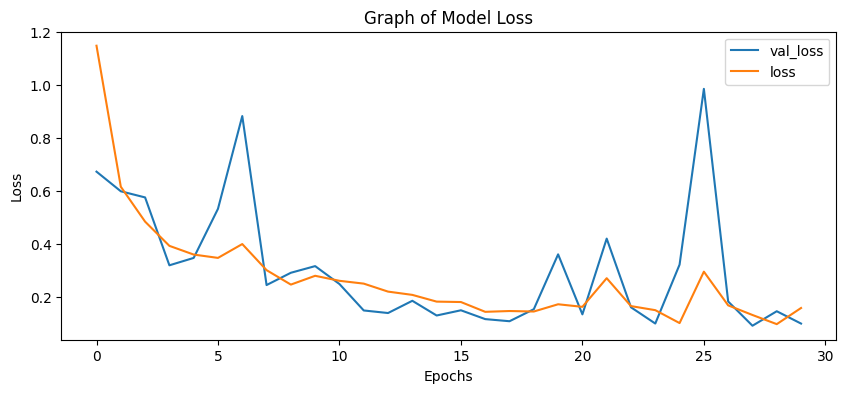

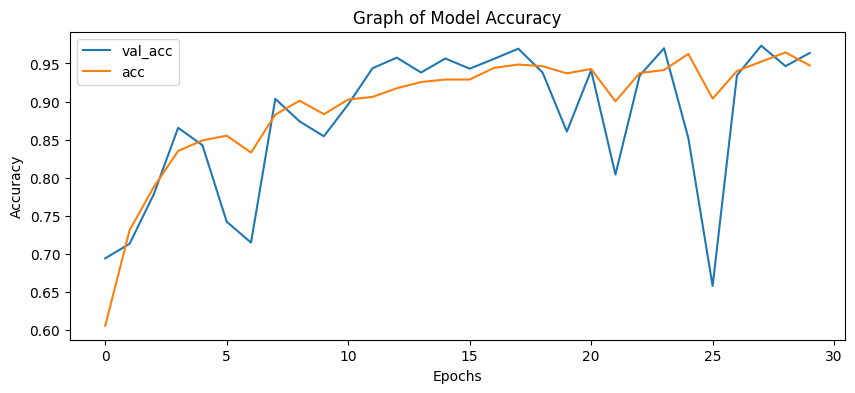

In [72]:
make_confusion_and_classification(baseline_model, 'Baseline Model')
visualize_model_performance(baseline_results)

In [54]:
model_1 = Sequential()

model_1.add(layers.Dense(128, activation='relu', input_shape=(49152,)))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

model_1.compile(optimizer='adam',metrics=['accuracy'], loss='categorical_crossentropy')
model_1.summary()

model_1_results = model_1.fit(X_train, y_train, epochs=100, batch_size=50,
                                  validation_data=(X_val, y_val), verbose=1, callbacks=early_stop)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               6291584   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6300100 (24.03 MB)
Trainable params: 6300100 (24.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
287/287 [==============================] - 4s 14ms/step - loss: 1.2191 - accuracy: 0.5134 - val_loss: 0.7229 - val_accuracy: 0.6523
Ep

Epoch 51/100
287/287 [==============================] - 4s 12ms/step - loss: 0.0734 - accuracy: 0.9739 - val_loss: 0.1659 - val_accuracy: 0.9425
Epoch 52/100
287/287 [==============================] - 4s 14ms/step - loss: 0.0469 - accuracy: 0.9847 - val_loss: 0.0387 - val_accuracy: 0.9844
Epoch 53/100
287/287 [==============================] - 4s 16ms/step - loss: 0.0692 - accuracy: 0.9786 - val_loss: 0.1257 - val_accuracy: 0.9448
Epoch 54/100
287/287 [==============================] - 4s 13ms/step - loss: 0.0836 - accuracy: 0.9728 - val_loss: 0.0355 - val_accuracy: 0.9877
Epoch 55/100
287/287 [==============================] - 4s 13ms/step - loss: 0.0997 - accuracy: 0.9672 - val_loss: 0.4099 - val_accuracy: 0.8298
Epoch 56/100
287/287 [==============================] - 4s 12ms/step - loss: 0.0517 - accuracy: 0.9835 - val_loss: 0.0402 - val_accuracy: 0.9877
Epoch 57/100
287/287 [==============================] - 5s 17ms/step - loss: 0.0764 - accuracy: 0.9735 - val_loss: 0.2131 - val_ac

/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 4s 15ms/step - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.0383 - val_accuracy: 0.9872
Epoch 66/100
287/287 [==============================] - 4s 14ms/step - loss: 0.1058 - accuracy: 0.9734 - val_loss: 1.3109 - val_accuracy: 0.7634
Epoch 67/100
287/287 [==============================] - 4s 14ms/step - loss: 0.2347 - accuracy: 0.9305 - val_loss: 0.0488 - val_accuracy: 0.9894
Epoch 68/100
287/287 [==============================] - 4s 14ms/step - loss: 0.0647 - accuracy: 0.9793 - val_loss: 0.1001 - val_accuracy: 0.9732
Epoch 69/100
287/287 [==============================] - 4s 14ms/step - loss: 0.1225 - accuracy: 0.9625 - val_loss: 0.0414 - val_accuracy: 0.9855
Epoch 70/100
287/287 [==============================] - 4s 13ms/step - loss: 0.0283 - accuracy: 0.9918 - val_loss: 0.0435 - val_accuracy: 0.9860
Epoch 71/100
287/287 [==============================] - 4s 12ms/step - loss: 0.0796 - accuracy: 0.9707 - val_loss: 0.1974 - val_accuracy: 0.903

The Accuracy for the training group was 99.85350370407104
The Loss for the training group was 0.011261445470154285
--------------------------------------
The Accuracy for the test group was 99.21875
The Loss for the test group was 0.034087177366018295
56/56 [==============================] - 0s 3ms/step


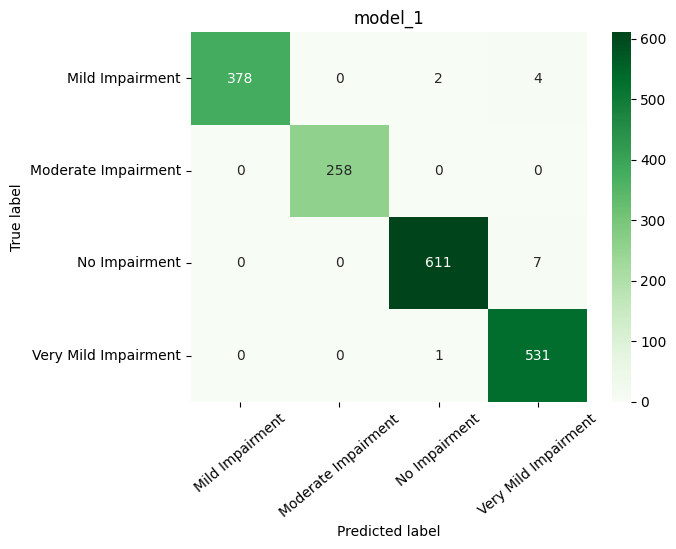

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       384
           1       1.00      1.00      1.00       258
           2       1.00      0.99      0.99       618
           3       0.98      1.00      0.99       532

    accuracy                           0.99      1792
   macro avg       0.99      0.99      0.99      1792
weighted avg       0.99      0.99      0.99      1792



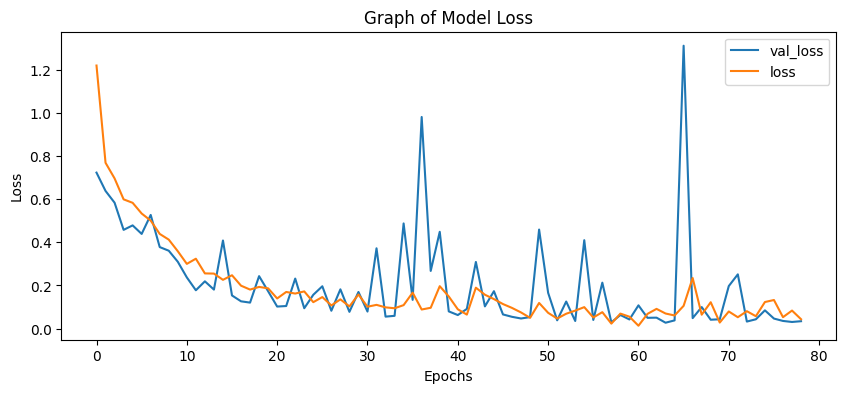

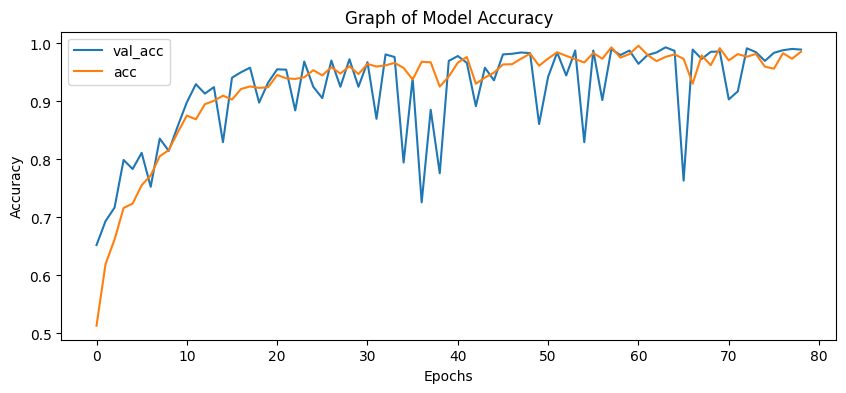

In [55]:
make_confusion_and_classification(model_1, 'model_1')
visualize_model_performance(model_1_results)

In [56]:
model_2 = Sequential()

model_2.add(layers.BatchNormalization(input_shape=(49152,)))
model_2.add(layers.Dropout(0.4))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

model_2.compile(optimizer=opt,metrics=['accuracy'], loss='categorical_crossentropy')
model_2.summary()

model_2_results = model_2.fit(X_train, y_train, epochs=100, batch_size=50,
                                  validation_data=(X_val, y_val), verbose=1, callbacks=early_stop)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 49152)             196608    
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 49152)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               6291584   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                      

The Accuracy for the training group was 35.71677803993225
The Loss for the training group was 1.3330457210540771
--------------------------------------
The Accuracy for the test group was 34.48660671710968
The Loss for the test group was 1.3379782438278198
56/56 [==============================] - 0s 4ms/step


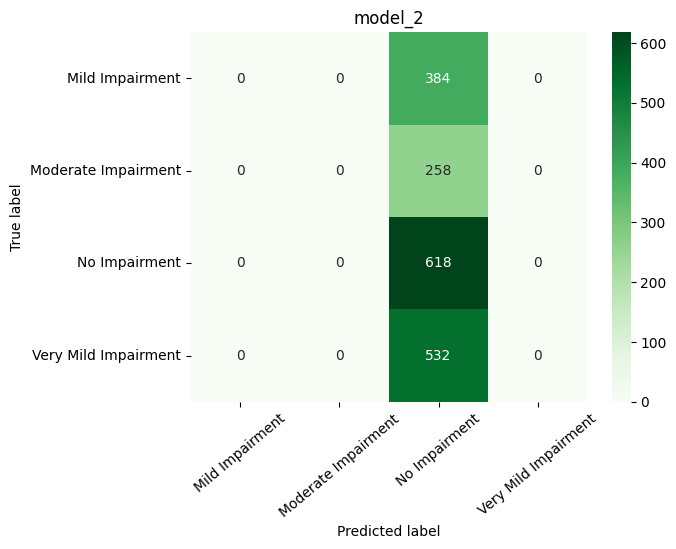

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       384
           1       0.00      0.00      0.00       258
           2       0.34      1.00      0.51       618
           3       0.00      0.00      0.00       532

    accuracy                           0.34      1792
   macro avg       0.09      0.25      0.13      1792
weighted avg       0.12      0.34      0.18      1792



/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

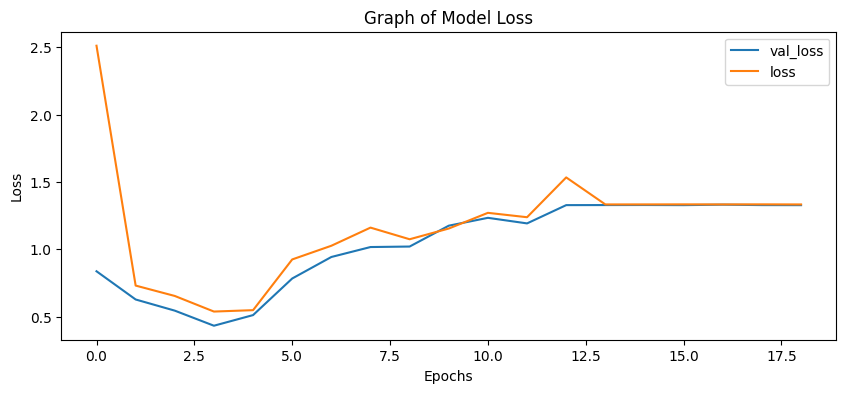

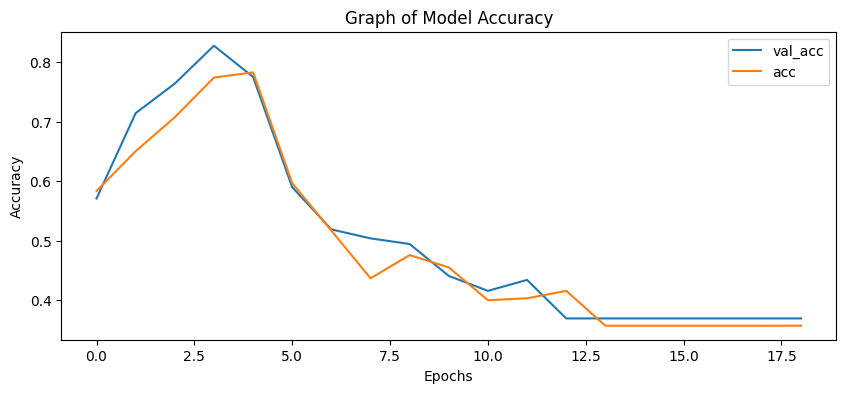

In [57]:
make_confusion_and_classification(model_2, 'model_2')
visualize_model_performance(model_2_results)

In [58]:
model_4 = Sequential()

model_4.add(layers.BatchNormalization(input_shape=(49152,)))
model_4.add(layers.Dropout(0.4))
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(4, activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

model_4.compile(optimizer=opt,metrics=['accuracy'], loss='categorical_crossentropy')
model_4.summary()

model_4_results = model_4.fit(X_train, y_train, epochs=100, batch_size=50,
                                  validation_data=(X_val, y_val), verbose=1, callbacks=early_stop)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 49152)             196608    
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 49152)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6291584   
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 4)                 260       
                                                      

/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 7s 23ms/step - loss: 0.0491 - accuracy: 0.9842 - val_loss: 0.0265 - val_accuracy: 0.9894
Epoch 13/100
287/287 [==============================] - 7s 24ms/step - loss: 0.0465 - accuracy: 0.9862 - val_loss: 0.0120 - val_accuracy: 0.9955
Epoch 14/100
287/287 [==============================] - 7s 24ms/step - loss: 0.0288 - accuracy: 0.9916 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 15/100
287/287 [==============================] - 7s 23ms/step - loss: 0.0337 - accuracy: 0.9899 - val_loss: 0.0189 - val_accuracy: 0.9961
Epoch 16/100
287/287 [==============================] - 7s 23ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.0433 - val_accuracy: 0.9894
Epoch 17/100
287/287 [==============================] - 7s 24ms/step - loss: 0.0400 - accuracy: 0.9878 - val_loss: 0.0155 - val_accuracy: 0.9939
Epoch 18/100
287/287 [==============================] - 7s 24ms/step - loss: 0.0438 - accuracy: 0.9874 - val_loss: 0.0049 - val_accuracy: 0.998

The Accuracy for the training group was 99.90931153297424
The Loss for the training group was 0.0029539463575929403
--------------------------------------
The Accuracy for the test group was 99.66517686843872
The Loss for the test group was 0.017935391515493393
56/56 [==============================] - 0s 5ms/step


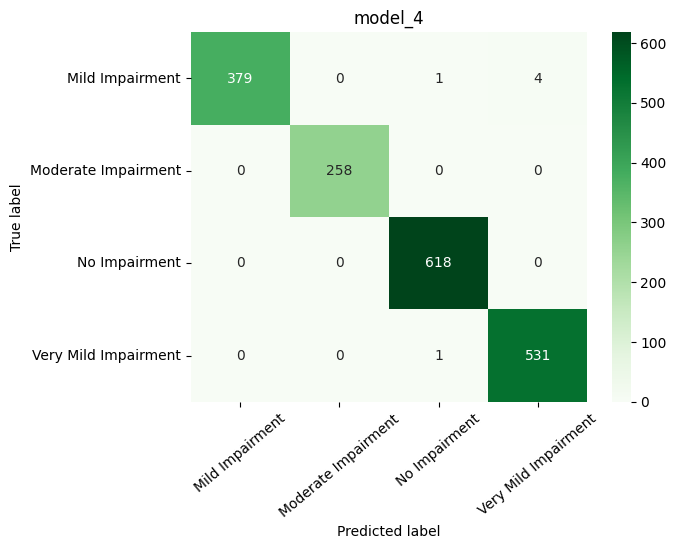

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       384
           1       1.00      1.00      1.00       258
           2       1.00      1.00      1.00       618
           3       0.99      1.00      1.00       532

    accuracy                           1.00      1792
   macro avg       1.00      1.00      1.00      1792
weighted avg       1.00      1.00      1.00      1792



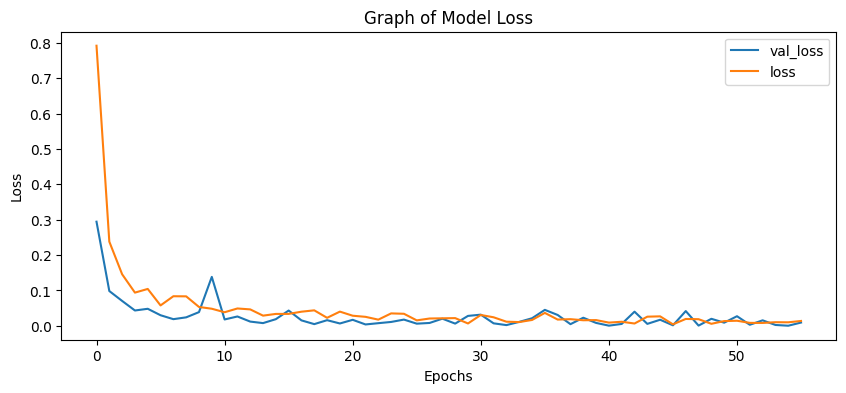

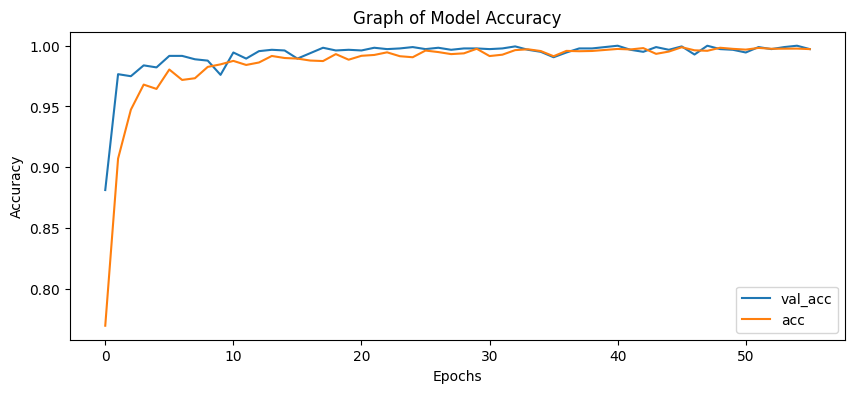

In [59]:
make_confusion_and_classification(model_4, 'model_4')
visualize_model_performance(model_4_results)

In [ ]:
custom_model = Sequential([
    Input(shape=(49152,)),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')        
], name = "cnn_model")

custom_model.summary()

OPT = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

custom_model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
custom_model_results = custom_model.fit(X_train, y_train, epochs=100, batch_size=50,
                                  validation_data=(X_val, y_val), verbose=1, callbacks=early_stop)

In [ ]:
make_confusion_and_classification(custom_model, 'custom_model')
visualize_model_performance(custom_model_results)

## K Nearest Neighbors Classifier


In [61]:
knn_baseline = KNeighborsClassifier(n_jobs=-1)
knn_baseline.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [68]:
print(classification_report(y_rem, knn_baseline.predict(X_rem), target_names=classes))



                      precision    recall  f1-score   support

     Mild Impairment       1.00      1.00      1.00       727
 Moderate Impairment       1.00      1.00      1.00       527
       No Impairment       1.00      1.00      1.00      1280
Very Mild Impairment       1.00      1.00      1.00      1050

           micro avg       1.00      1.00      1.00      3584
           macro avg       1.00      1.00      1.00      3584
        weighted avg       1.00      1.00      1.00      3584
         samples avg       1.00      1.00      1.00      3584



/Users/lucasf/miniconda/envs/learn-env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
print('Training score:', knn_baseline.score(X_train, y_train) * 100)
print('Test Score:', knn_baseline.score(X_rem, y_rem) * 100)


Training score: 99.99302406696896
Test Score: 99.91629464285714
